# 6. 영화리뷰 텍스트 감성분석하기 🌼☃️🐳😍

## (1) 텍스트를 숫자로 표현하는 방법

### 🌼 예제: 3개의 짧은 문장으로 이루어진 텍스트 데이터를 처리
>i feel hungry  
>i eat lunch  
>now i feel happy

In [ ]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

#### - 모든 문장을 단어 단위로 쪼갠 후에 파이썬 딕셔너리(dict) 자료구조로 표현

In [ ]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

#### - 텍스트를 숫자로 변환하기 위해 "딕셔너리 {텍스트:인덱스}" 구조로 바꾸기

In [ ]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

In [ ]:
# 이 딕셔너리는 단어를 주면 그 단어의 인덱스를 반환하는 방식으로 사용 가능
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

#### - 텍스트 데이터를 숫자로 바꿔 표현해보기

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

#### - get_encoded_sentence 함수를 통해 아래와 같이 문장 여러개 한번에 매핑하기

> `<BOS>` -> 1  
> i -> 3  
> eat -> 6  
> lunch -> 7  

In [ ]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

#### - 반대로, encode된 벡터를 decode하여 다시 원래 텍스트 데이터로 복구하기

In [ ]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

In [ ]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

## (2) Embedding 레이어의 등장

## 🌼우리가 하려는 것:  단어와 그 단어의 의미를 나타내는 벡터를 짝짓는 것  
> **단어의 의미를 나타내는 벡터 = 훈련 가능한 파라미터**로 놓고 이를 딥러닝을 통해 학습해서 최적화하게 됩니다.   
> `Tensorflow, Pytorch` 등의 딥러닝 프레임워크들은 이러한 **의미 벡터 파라미터**를 구현한 `Embedding 레이어`를 제공합니다.

In [ ]:
# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다. 

import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
output = embedding(raw_inputs)
print(output)

## 🦀Key Point🦀
- Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 한다. 
- raw_inputs의 3개 벡터의 길이는 각각 4, 4, 5.

#### - Tensorflow의`tf.keras.preprocessing.sequence.pad_sequences` (기능)함수를 통해 문장 벡터 뒤에 패딩(`<PAD>`)을 추가하여 길이 일정하게 맞춰주기

In [ ]:
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'], # <PAD>는 0에 매핑되어 있음
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

#### 짧은 문장 뒤쪽이 0으로 채워지는 것을 확인 !! 
#### - output = embedding(raw_inputs) 다시 시도

In [ ]:
vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype=object)
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

## (3) 시퀀스 데이터를 다루는 RNN
> 🌼 텍스트 데이터를 다루는 데 주로 사용되는 딥러닝 모델은 바로 Recurrent Neural Network(RNN)입니다.   
    RNN은 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델로 알려져 있습니다.

- RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었다.
= Stateful 함 !! 

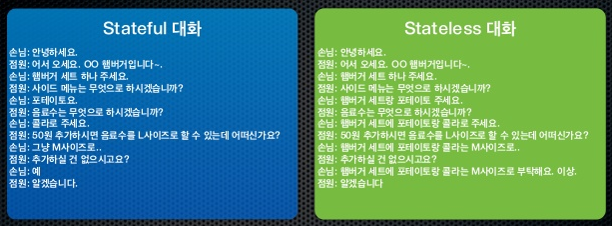



**참고 영상: [김성훈 교수님 모두의 딥러닝 12강 RNN](https://youtu.be/-SHPG_KMUkQ)🌼**
 **[감정 분석에서 RNN 활용]**

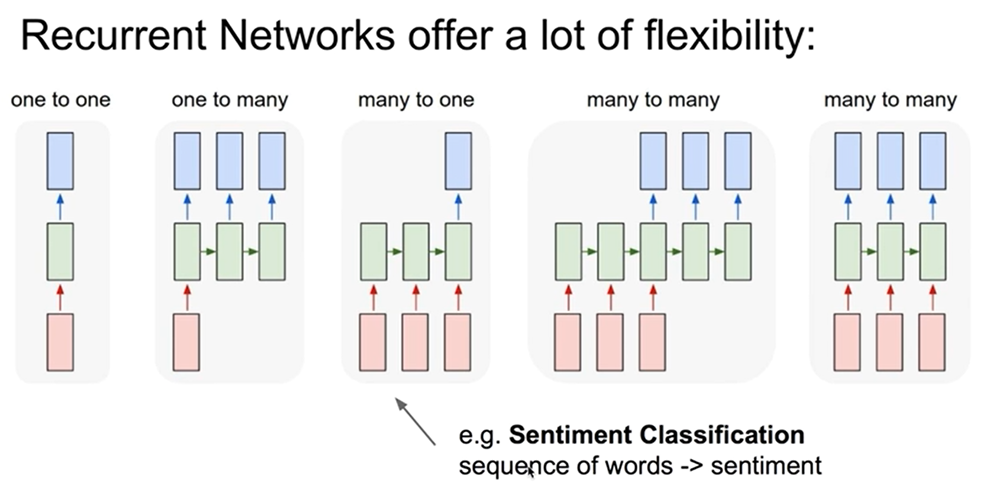
                                                

#### - RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현해보기

In [ ]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

## 꼭 RNN이어야 할까? 

1. 1-D Convolution Neural Network(1-D CNN) 사용

2. 이미지 분류기를 구현하면서 2-D CNN

3. GlobalMaxPooling1D() 레이어 하나만 사용